### Imports

In [1]:
# !pip install timm
# !pip install albumentations

In [2]:
## Filter unwanted warnings
import warnings
warnings.filterwarnings('ignore')

import os
import random
from random import sample
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split

import timm

import tarfile

np.random.seed(10)
torch.manual_seed(10)

### Data Loading and Pre-Processing

In [3]:
file = tarfile.open('/kaggle/input/lensesdata/lenses.tgz')
file.extractall('/kaggle/working/')

The extracted folder contains two subfolders 'sub' and 'no_sub' which are basically the labels of the images.

In [4]:
folders = glob.glob('/kaggle/working//lenses/*')
folders

['/kaggle/working//lenses/no_sub', '/kaggle/working//lenses/sub']

I created lists of images and labels

no_sub -> 0

sub -> 1

In [5]:
images, labels = [], []

label_2_idx_dict = {"no_sub" : 0, "sub" : 1}
idx_2_label_dict = {0 : 'no_sub', 1 : 'sub'}

for folder in folders:
  for files in glob.glob(folder+'/*'):
    images.append(files)
    labels.append(label_2_idx_dict[files.split('/')[-2]])

Created a pandas DataFrame with the images and labels lists.

In [7]:
data = pd.DataFrame({'image' : images, 'labels' : labels})
data

,image,labels
0,/kaggle/working//lenses/no_sub/image_352923224...,0
1,/kaggle/working//lenses/no_sub/image_332662206...,0
2,/kaggle/working//lenses/no_sub/image_314772419...,0
3,/kaggle/working//lenses/no_sub/image_144643724...,0
4,/kaggle/working//lenses/no_sub/image_182155089...,0
...,...,...
9995,/kaggle/working//lenses/sub/image_292781113144...,1
9996,/kaggle/working//lenses/sub/image_120103937910...,1
9997,/kaggle/working//lenses/sub/image_274852885645...,1
9998,/kaggle/working//lenses/sub/image_233775041437...,1


Checking for class imbalance

In [8]:
data['labels'].value_counts()

0    5000
1    5000
Name: labels, dtype: int64

I split the data into train, val and test dataset

In [9]:
train_df, test_df = train_test_split(data, test_size=0.1, random_state=10)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=10)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(train_df.shape, test_df.shape, val_df.shape)

(7650, 2) (1000, 2) (1350, 2)


Plotting the images

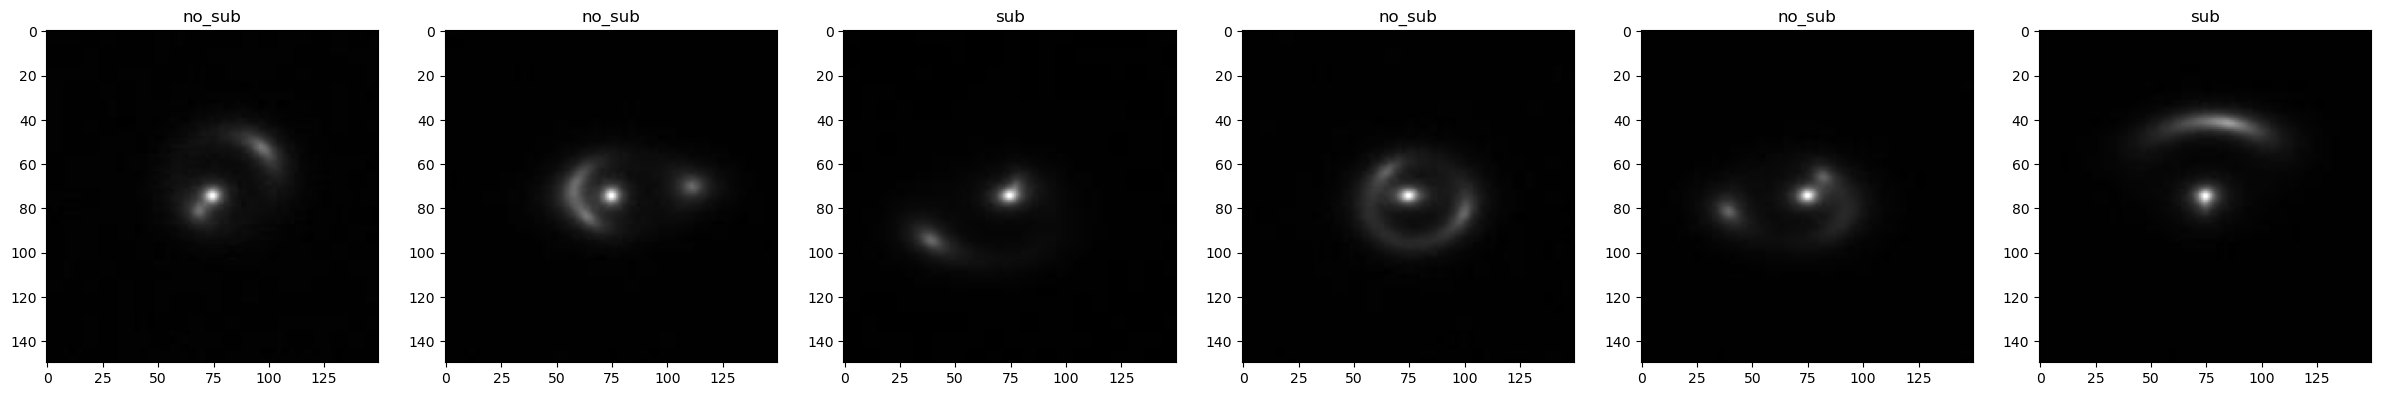

In [10]:
fig, ax = plt.subplots(1, 6)
fig.set_figheight(30)
fig.set_figwidth(30)
for i in range(6):
  idx = np.random.randint(0, train_df.shape[0])
  img_arr = cv.imread(str(train_df.iloc[idx]['image']))
  ax[i].imshow(img_arr)
  title = idx_2_label_dict[train_df.iloc[idx]['labels']]
  ax[i].set_title(title)

In [11]:
img_arr.shape

(150, 150, 3)

Creating the Dataset Class

I defined a custom dataset class called CreateDataset which inherits from the PyTorch Dataset class. It takes a pandas DataFrame,an optional transforms object as input and an is_test parameter. The len function returns the length of the DataFrame. The getitem function loads a image using the cv2 library, normalizes the image using max normalization, applies the provided transforms (if any). If is_test is True, only the image is returned, otherwise, the image and its corresponding label are returned as a tuple.

In [12]:
class CreateDataset(Dataset):
  def __init__(self, df, transforms = None, is_test = False):
    self.df = df
    self.transforms = transforms
    self.is_test = is_test

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    img = cv.imread(self.df.iloc[idx]['image'])
    img = img / np.max(img)

    if self.transforms:
        aug = self.transforms(image=img)
        img = aug['image']

    if self.is_test:
      return img
    else:
      labels = torch.tensor([self.df.iloc[idx]['labels']], dtype = torch.float32)

      return img, labels

Augmentations

I have defined two different augmentations for the train and test sets. For the training set, I used horizontal and vertical flips, an advanced blur with various limits on blur and noise, and set the images to be transformed to tensors using ToTensorV2().  I also used CenterCrop which reduces the image size to (100, 100, 3), I used this to remove the redundant pixels. For the test set, I used the same CenterCrop and transformed the images to tensors using ToTensorV2().

In [13]:
train_transform = A.Compose([
    A.CenterCrop(height = 100, width = 100, p=1.0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.AdvancedBlur(blur_limit=(3, 7), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, 
                   beta_limit=(0.5, 8.0), noise_limit=(0.7, 1), always_apply=False, p=0.3),
    ToTensorV2()
])

test_transform = A.Compose([
    A.CenterCrop(height = 100, width = 100, p=1.0),
    ToTensorV2()
])

Checking if the CreateDataset function is working, also plotting to see the augmentations applied to the images. As you can see the images are center cropped

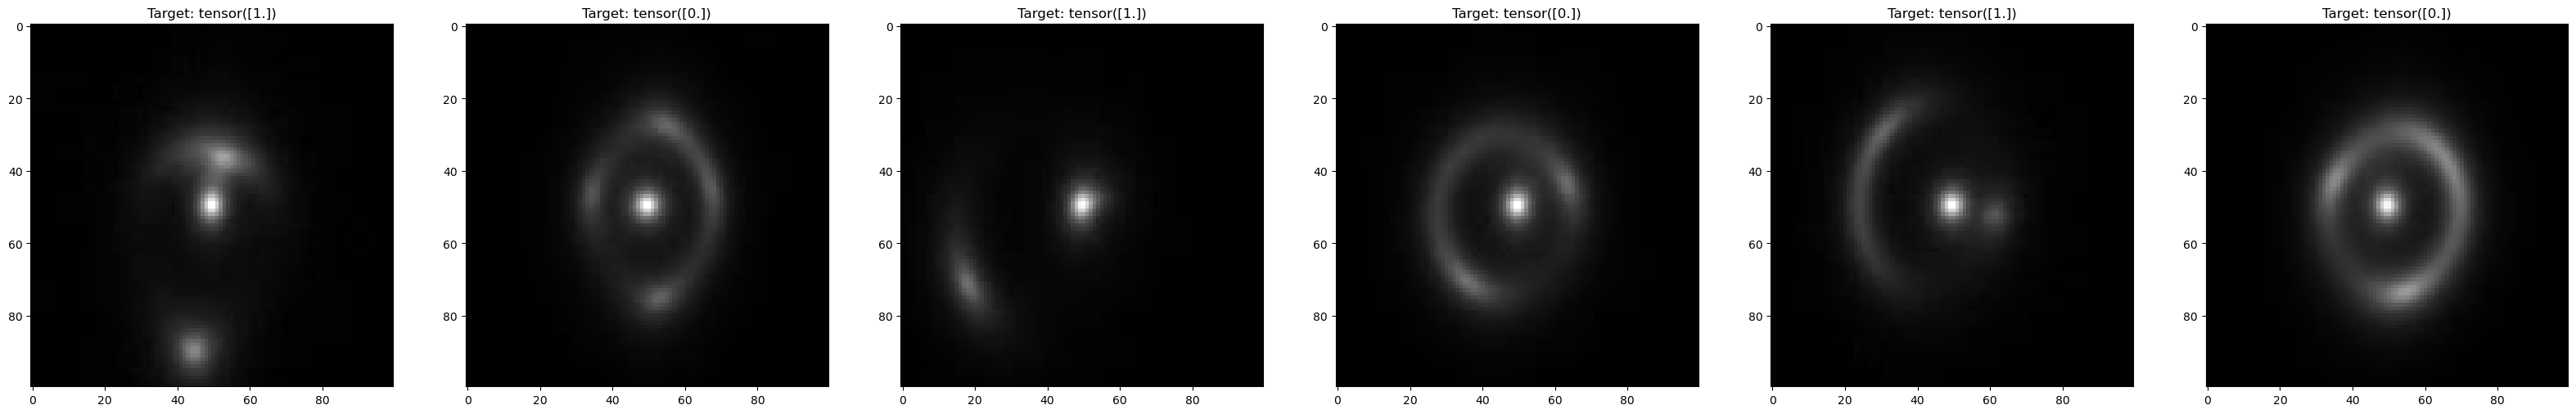

In [14]:
dummy_data = CreateDataset(train_df, transforms=train_transform)
dummy_loader = DataLoader(dummy_data,
                         shuffle=True,
                    batch_size=6)
a,b = next(iter(dummy_loader))

fig, ax = plt.subplots(1, 6)
fig.set_figheight(25)
fig.set_figwidth(40)
for i in range(6):
  idx = np.random.randint(0, train_df.shape[0])
  ax[i].imshow(a[i].T.squeeze(0))
  title = f"Target: {b[i]}"
  ax[i].set_title(title)

Forming the dataset

Pytorch standard DataLoader function, which creates PyTorch data loaders for the training, validation, and test datasets, which can be used to load batches of data for training or testing machine learning models.

In [15]:
train_ds = CreateDataset(train_df, transforms=train_transform)
val_ds = CreateDataset(val_df, transforms=test_transform)
test_ds = CreateDataset(test_df, transforms=test_transform)
len(train_ds), len(val_ds), len(test_ds)

(7650, 1350, 1000)

In [16]:
BATCH_SIZE = 32

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE,shuffle=False, drop_last=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,drop_last=False) 

### The Model

I created a custom model class named "CustomMobileViT". The backbone of the model is loaded from the timm library using the "create_model" function with the "mobilevitv2_150" vision transformer architecture and pretrained weights. The backbone model is used to extract features from the input image. I used this particular model because it didn't have any fixed input size and also it gave the best results.

I added some custom blocks to the backbone model in the "custom_blocks" sequential container. The first custom block is a convolutional block consisting of a convolutional layer, batch normalization, and PReLU activation function. The second custom block is the squeeze and excitation block, which helps the model to adaptively recalibrate the feature responses.

After the squeeze and excitation block, dropout regularization is applied with a rate of "dropout_rate". Then, another convolutional block with the same structure as the previous block is added. Another squeeze and excitation block is added after this block.

Then, adaptive average pooling is used to reduce the spatial dimensions of the feature map to 1x1. Then, the output is flattened and passed through a dropout layer. Finally, a linear layer is used to map the features to the desired output size.

I used the squeeze and excitation block (SE) because, the SE block learns a channel-wise weighting scheme that can be used to selectively amplify or attenuate the importance of each channel in the feature map, based on its relevance to the task at hand. This allows the network to focus on the most informative channels and ignore the less informative ones, thus improving its ability to capture discriminative features and reduce noise. 

In summary, the model consists of a backbone network that extracts features from the input image, followed by custom blocks that refine the features, and finally a linear layer that maps the refined features to the desired output size.

In [18]:
class SEBlock(nn.Module):
    """

    The SE block takes the feature map from the previous layer as input and applies a global average pooling operation 
    to reduce the spatial dimensions of the feature map to 1x1. This produces a channel-wise feature vector that 
    summarizes the importance of each channel. This vector is then passed through two convolutional layers, 
    where the first layer reduces the number of channels by a factor specified by the se_ratio parameter, 
    and the second layer restores the original number of channels. 
    The output of the second layer is then element-wise multiplied with the input feature map to produce
    the final output of the SE block.

    """
    def __init__(self, in_channels, se_ratio=0.25):
        super(SEBlock, self).__init__()
        
        self.se_reduce = nn.Conv2d(in_channels=in_channels, out_channels=int(in_channels * se_ratio), kernel_size=1)
        self.se_expand = nn.Conv2d(in_channels=int(in_channels * se_ratio), out_channels=in_channels, kernel_size=1)
        
    def forward(self, x):
        se_tensor = F.avg_pool2d(x, kernel_size=x.shape[2:])
        se_tensor = self.se_expand(F.relu(self.se_reduce(se_tensor)))
        return x * se_tensor.sigmoid()

class CustomMobileViT(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.2):
        super(CustomMobileViT, self).__init__()

        # Load the backbone model from the timm library
        self.backbone = timm.create_model('mobilevitv2_150', pretrained=True)

        # Add custom blocks to the model
        self.custom_blocks = nn.Sequential(
            nn.Conv2d(in_channels=self.backbone.num_features, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.PReLU(),
            
            SEBlock(in_channels=256),
            
            nn.Dropout(p=dropout_rate),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.PReLU(),
            
            SEBlock(in_channels=128),
            
            nn.Dropout(p=dropout_rate),
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=128, out_features=num_classes)
        )

    def forward(self, x):
        # Pass the input through the backbone model
        backbone_output = self.backbone.forward_features(x)

        # Pass the backbone output through the custom blocks
        output = self.custom_blocks(backbone_output)

        return output

In [19]:
model = CustomMobileViT(num_classes = 1)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-mvit-weights/mobilevitv2_150-737c5019.pth" to /root/.cache/torch/hub/checkpoints/mobilevitv2_150-737c5019.pth


In [20]:
## Checking if the model is working correctly
x = torch.randn(BATCH_SIZE, 3, 100, 100)
print(model(x).shape)

torch.Size([32, 1])


In [23]:
## Setting the Device to CUDA if GPU is available else CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


### Training

The training and validation follows the standard PyTorch training pipeline.

Here I am using BCEWithLogitsLoss as my loss function.

In [24]:
def train_model(model,
                train_dataloader,
                val_dataloader,
                dataset_size, 
                val_dataset_size,
                optimizer, 
                scheduler, 
                num_epochs):
    
    model = model.to(device)
    
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []

    criterion = nn.BCEWithLogitsLoss()
    
    for epoch in range(num_epochs):
        print('-->Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)
        
        # ----------------- Training -----------------
        model.train()

        running_loss = 0.0
        running_acc = 0.0
                
        ## Iterate over data.
        for batch in tqdm(train_dataloader):
            inputs = batch[0]
            labels = batch[1].squeeze()
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            
            outputs = model(inputs)
            
            loss = criterion(outputs.squeeze(), labels)

            ## Accuracy Calculation
            ### Applied a sigmoid function to turn the raw outputs into probabilities
            logits = F.sigmoid(outputs)
            logits = logits.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
                
            acc = accuracy_score(labels, logits > 0.5)  ## Logits > 0.5 will be 1 and < 0.5 will be 0

            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss
            running_acc += acc
        
        epoch_loss = running_loss / dataset_size
        epoch_acc = running_acc / dataset_size
        train_acc.append(epoch_acc)
        train_loss.append(epoch_loss.cpu().detach().numpy())
        print('Train Loss: {:.4f} --- Train Accuracy: {:.4f}'.format(epoch_loss, epoch_acc))
        
        
        # ------------ Validation -----------------
        model.eval()
        
        running_val_loss, running_val_acc = 0.0, 0.0
        
        for batch in tqdm(val_dataloader):
            inputs, labels = batch[0], batch[1].squeeze()
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            
            with torch.no_grad():
                outputs = model(inputs)
            
            loss = criterion(outputs.squeeze(), labels)
            
            logits = F.sigmoid(outputs)
            logits = logits.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            
            acc = accuracy_score(labels, logits > 0.5)

            running_val_loss  += loss
            running_val_acc += acc
        
        epoch_val_loss = running_val_loss / val_dataset_size
        epoch_val_acc = running_val_acc / val_dataset_size
        val_acc.append(epoch_val_acc)
        val_loss.append(epoch_val_loss.cpu().detach().numpy())
        print('Val Loss: {:.4f} --- Val Accuracy: {:.4f}\n'.format(epoch_val_loss, epoch_val_acc))
        
        scheduler.step()  ## The learning rate scheduler step
        
    print(f"\n\nTotal Training Loss: {sum(train_loss) / num_epochs} ---- Total Training Accuracy: {sum(train_acc) / num_epochs}")
    print(f"Total Validation Loss: {sum(val_loss) / num_epochs} --- Total Validation Accuracy: {sum(val_acc) / num_epochs}\n")
    
    return model, train_acc, train_loss, val_acc, val_loss

I found the AdamW optimizer to give the best results. It is a variation of the popular Adam optimizer, which incorporates weight decay regularization into the optimization process to prevent overfitting. 

I also used Cosine Annealing as my learning rate scheduler.


In [25]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

training_epochs = 20
optimizer = optim.AdamW(model.parameters(),lr=2e-3, weight_decay=1e-4)
lr_sch = CosineAnnealingLR(optimizer, T_max = 20, eta_min = 1e-6, verbose = True)

model = model.to(device)

model_ft, train_acc, train_loss, val_acc, val_loss = train_model(model,
                                                                 train_dl,
                                                                 val_dl,
                                                                 len(train_dl),
                                                                 len(val_dl),
                                                                 optimizer,
                                                                 lr_sch,
                                                                 num_epochs=training_epochs)

Adjusting learning rate of group 0 to 2.0000e-03.
-->Epoch 0/19
--------------------


100%|██████████| 239/239 [00:59<00:00,  4.01it/s]


Train Loss: 0.6961 --- Train Accuracy: 0.5004


100%|██████████| 43/43 [00:02<00:00, 14.82it/s]


Val Loss: 0.6935 --- Val Accuracy: 0.5087

Adjusting learning rate of group 0 to 1.9877e-03.
-->Epoch 1/19
--------------------


100%|██████████| 239/239 [00:49<00:00,  4.79it/s]


Train Loss: 0.6923 --- Train Accuracy: 0.5137


100%|██████████| 43/43 [00:02<00:00, 15.62it/s]


Val Loss: 0.6935 --- Val Accuracy: 0.5141

Adjusting learning rate of group 0 to 1.9511e-03.
-->Epoch 2/19
--------------------


100%|██████████| 239/239 [00:50<00:00,  4.74it/s]


Train Loss: 0.6315 --- Train Accuracy: 0.6285


100%|██████████| 43/43 [00:02<00:00, 15.64it/s]


Val Loss: 0.6915 --- Val Accuracy: 0.5845

Adjusting learning rate of group 0 to 1.8911e-03.
-->Epoch 3/19
--------------------


100%|██████████| 239/239 [00:49<00:00,  4.81it/s]


Train Loss: 0.3376 --- Train Accuracy: 0.8438


100%|██████████| 43/43 [00:03<00:00, 14.19it/s]


Val Loss: 2.4025 --- Val Accuracy: 0.5228

Adjusting learning rate of group 0 to 1.8091e-03.
-->Epoch 4/19
--------------------


100%|██████████| 239/239 [00:50<00:00,  4.75it/s]


Train Loss: 0.1799 --- Train Accuracy: 0.9227


100%|██████████| 43/43 [00:02<00:00, 14.80it/s]


Val Loss: 0.1545 --- Val Accuracy: 0.9469

Adjusting learning rate of group 0 to 1.7073e-03.
-->Epoch 5/19
--------------------


100%|██████████| 239/239 [00:50<00:00,  4.71it/s]


Train Loss: 0.1312 --- Train Accuracy: 0.9474


100%|██████████| 43/43 [00:02<00:00, 15.12it/s]


Val Loss: 0.1138 --- Val Accuracy: 0.9460

Adjusting learning rate of group 0 to 1.5880e-03.
-->Epoch 6/19
--------------------


100%|██████████| 239/239 [00:52<00:00,  4.52it/s]


Train Loss: 0.1099 --- Train Accuracy: 0.9542


100%|██████████| 43/43 [00:02<00:00, 14.82it/s]


Val Loss: 0.1693 --- Val Accuracy: 0.9426

Adjusting learning rate of group 0 to 1.4543e-03.
-->Epoch 7/19
--------------------


100%|██████████| 239/239 [00:49<00:00,  4.79it/s]


Train Loss: 0.1013 --- Train Accuracy: 0.9586


100%|██████████| 43/43 [00:02<00:00, 15.62it/s]


Val Loss: 0.4698 --- Val Accuracy: 0.8006

Adjusting learning rate of group 0 to 1.3094e-03.
-->Epoch 8/19
--------------------


100%|██████████| 239/239 [00:51<00:00,  4.67it/s]


Train Loss: 0.0744 --- Train Accuracy: 0.9690


100%|██████████| 43/43 [00:02<00:00, 15.70it/s]


Val Loss: 0.3059 --- Val Accuracy: 0.8779

Adjusting learning rate of group 0 to 1.1569e-03.
-->Epoch 9/19
--------------------


100%|██████████| 239/239 [00:50<00:00,  4.71it/s]


Train Loss: 0.0675 --- Train Accuracy: 0.9729


100%|██████████| 43/43 [00:02<00:00, 15.52it/s]


Val Loss: 0.1513 --- Val Accuracy: 0.9387

Adjusting learning rate of group 0 to 1.0005e-03.
-->Epoch 10/19
--------------------


100%|██████████| 239/239 [00:50<00:00,  4.71it/s]


Train Loss: 0.0619 --- Train Accuracy: 0.9774


100%|██████████| 43/43 [00:02<00:00, 15.22it/s]


Val Loss: 0.0467 --- Val Accuracy: 0.9797

Adjusting learning rate of group 0 to 8.4414e-04.
-->Epoch 11/19
--------------------


100%|██████████| 239/239 [00:51<00:00,  4.66it/s]


Train Loss: 0.0478 --- Train Accuracy: 0.9812


100%|██████████| 43/43 [00:02<00:00, 15.47it/s]


Val Loss: 0.0419 --- Val Accuracy: 0.9847

Adjusting learning rate of group 0 to 6.9164e-04.
-->Epoch 12/19
--------------------


100%|██████████| 239/239 [00:51<00:00,  4.67it/s]


Train Loss: 0.0570 --- Train Accuracy: 0.9795


100%|██████████| 43/43 [00:02<00:00, 15.58it/s]


Val Loss: 0.0371 --- Val Accuracy: 0.9847

Adjusting learning rate of group 0 to 5.4674e-04.
-->Epoch 13/19
--------------------


100%|██████████| 239/239 [00:51<00:00,  4.65it/s]


Train Loss: 0.0300 --- Train Accuracy: 0.9889


100%|██████████| 43/43 [00:02<00:00, 14.65it/s]


Val Loss: 0.3067 --- Val Accuracy: 0.9104

Adjusting learning rate of group 0 to 4.1301e-04.
-->Epoch 14/19
--------------------


100%|██████████| 239/239 [00:51<00:00,  4.68it/s]


Train Loss: 0.0227 --- Train Accuracy: 0.9915


100%|██████████| 43/43 [00:02<00:00, 14.88it/s]


Val Loss: 0.0248 --- Val Accuracy: 0.9920

Adjusting learning rate of group 0 to 2.9375e-04.
-->Epoch 15/19
--------------------


100%|██████████| 239/239 [00:50<00:00,  4.70it/s]


Train Loss: 0.0171 --- Train Accuracy: 0.9941


100%|██████████| 43/43 [00:02<00:00, 14.84it/s]


Val Loss: 0.0161 --- Val Accuracy: 0.9927

Adjusting learning rate of group 0 to 1.9189e-04.
-->Epoch 16/19
--------------------


100%|██████████| 239/239 [00:50<00:00,  4.72it/s]


Train Loss: 0.0139 --- Train Accuracy: 0.9944


100%|██████████| 43/43 [00:03<00:00, 14.31it/s]


Val Loss: 0.0117 --- Val Accuracy: 0.9956

Adjusting learning rate of group 0 to 1.0994e-04.
-->Epoch 17/19
--------------------


100%|██████████| 239/239 [00:50<00:00,  4.78it/s]


Train Loss: 0.0093 --- Train Accuracy: 0.9969


100%|██████████| 43/43 [00:02<00:00, 15.34it/s]


Val Loss: 0.0120 --- Val Accuracy: 0.9978

Adjusting learning rate of group 0 to 4.9919e-05.
-->Epoch 18/19
--------------------


100%|██████████| 239/239 [00:51<00:00,  4.67it/s]


Train Loss: 0.0071 --- Train Accuracy: 0.9976


100%|██████████| 43/43 [00:02<00:00, 15.66it/s]


Val Loss: 0.0073 --- Val Accuracy: 0.9978

Adjusting learning rate of group 0 to 1.3306e-05.
-->Epoch 19/19
--------------------


100%|██████████| 239/239 [00:51<00:00,  4.66it/s]


Train Loss: 0.0078 --- Train Accuracy: 0.9965


100%|██████████| 43/43 [00:02<00:00, 15.29it/s]


Val Loss: 0.0089 --- Val Accuracy: 0.9971

Adjusting learning rate of group 0 to 1.0000e-06.


Total Training Loss: 0.1648132396163419 ---- Total Training Accuracy: 0.9054589435146442
Total Validation Loss: 0.3179370201425627 --- Total Validation Accuracy: 0.8707727713178295



### Post-Training

Saving model weights

In [26]:
PATH = "ExploringTransformers_weights.h5"
torch.save(model_ft.state_dict(), PATH)

Loading trained model weights

In [27]:
new_model = CustomMobileViT(num_classes = 1).to(device)
new_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Loss and Accuracy plots

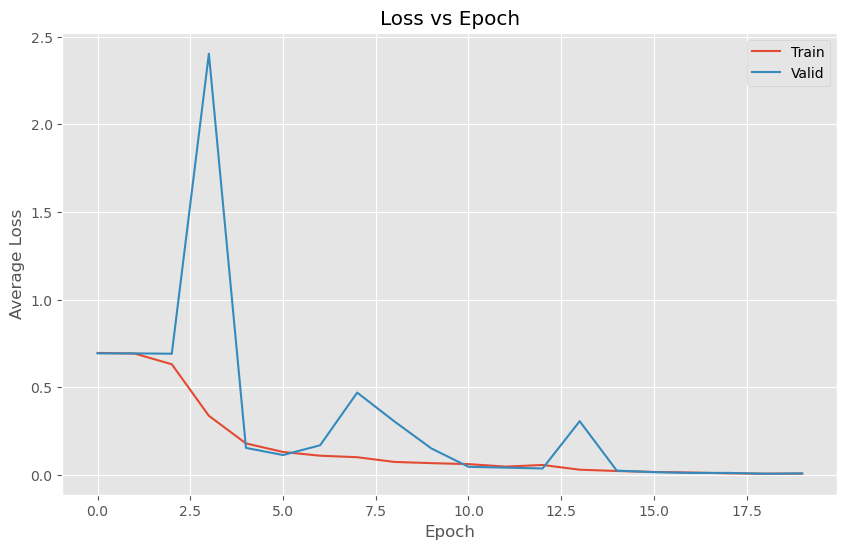

In [28]:
# # Plot losses
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.title('Loss vs Epoch')
plt.show()

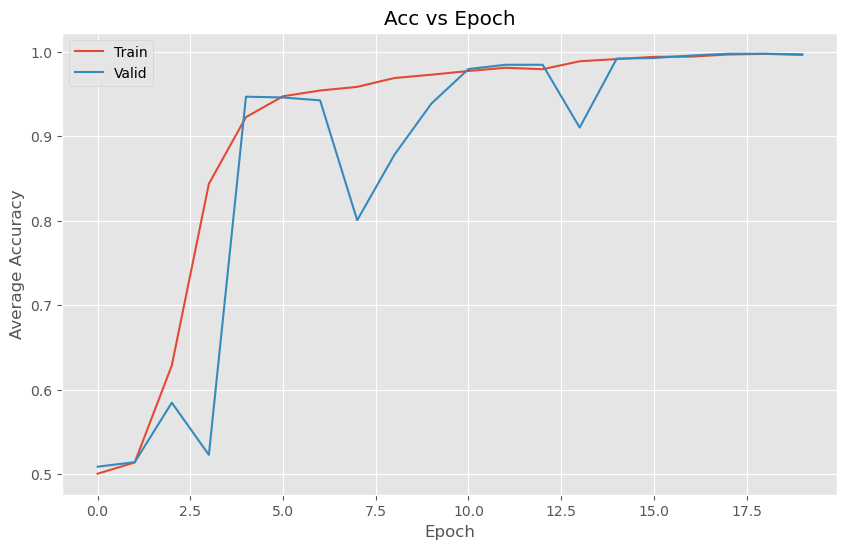

In [29]:
# Plot accuracy
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.legend()
plt.title('Acc vs Epoch')
plt.show()

### Evaluation

Testing loop

In [30]:
def test_model(model, dataloader):
    model.eval()
    model = model.to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    
    y_scores = []
    labels_list = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs, labels = batch[0], batch[1].squeeze()
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            
            labels_list.append(labels.detach().cpu().numpy())
            
            outputs = model(inputs)
            outputs = outputs.sigmoid()
            
            y_scores += [outputs.detach().cpu()]
            
        y_scores = torch.cat(y_scores).cpu().numpy()
        
    return y_scores, labels_list
    
## y_scores contains all the model predictions (the probabilites of each class)
## labels_list contains the actual values

In [31]:
y_scores, labels_list = test_model(model_ft, test_dl)

100%|██████████| 32/32 [00:02<00:00, 15.65it/s]


In [32]:
def flatten(my_list):
    flattened_list = [x for sublist in my_list for x in sublist]
    return flattened_list

labels = np.array(flatten(labels_list))
labels.shape, y_scores.shape

((1000,), (1000, 1))

ROC Curve

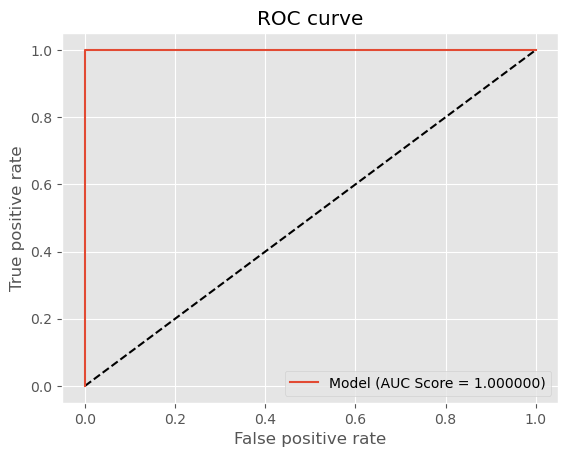

In [36]:
y_test = labels # ground_truth
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model (AUC Score = {:.6f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('ExploringTransformers-ROC_Curve.png')
plt.show()

In [34]:
y_pred = [1 if score > 0.5 else 0 for score in y_scores]

In [35]:
test_acc = accuracy_score(y_test, y_pred)

print(f"Test Acc: {test_acc}\nAUC Score: {roc_auc}")

Test Acc: 0.998
AUC Score: 1.0
